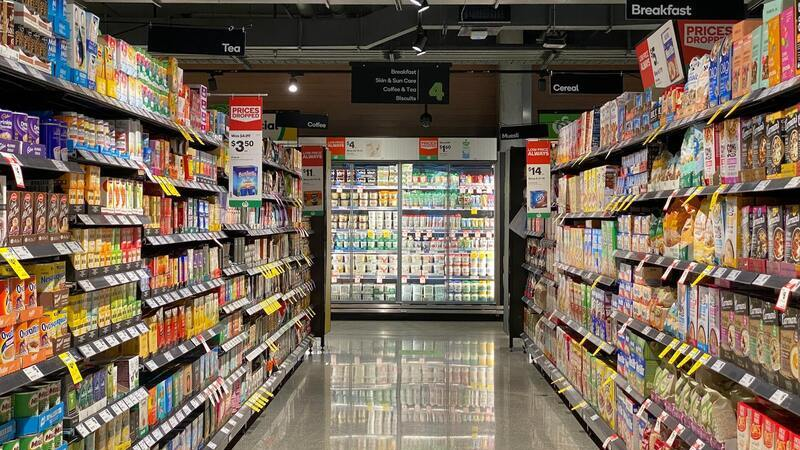


---

### SUMMARY

1. [Read the Data](#1)
2. [Average Sales, Seasonal Features and Oil Prices](#2)
3. [Sales by Season, Store and Article Type](#3)

---

# 1. Read the Data
<a id="1"></a>

## 1.1 Read the Data

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.linear_model import LinearRegression
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from xgboost import XGBRegressor
import plotly.express as px
import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))   

In [ ]:
### READ THE DATA ###
path = '/kaggle/input/store-sales-time-series-forecasting/'
os.listdir(path)

data_oil=pd.read_csv(path+'oil.csv')
data_holidays_events=pd.read_csv(path+'holidays_events.csv')
data_stores=pd.read_csv(path+'stores.csv')
data_train=pd.read_csv(path+'train.csv',parse_dates=['date'])
data_test=pd.read_csv(path+'test.csv',parse_dates=['date'])
data_transactions=pd.read_csv(path+'transactions.csv')
data_submission=pd.read_csv(path+'sample_submission.csv')

## 1.2 Features and Their Meaning

#### data_train

Main dataset. It contains the sales and the corresponding dates.

1. id: item id
2. date: date on record
3. store_nbr: store number
4. family: product family
5. sales: number of sales
6. onpromotion: total number of items in a product family which were on promotion at a store at a given date

In [ ]:
print(f'Number of train_data samples: {data_train.shape} \n')
print(data_train.info(),'\n')
print(data_train.head(),'\n')

As shown below, there ara gaps in the dates. Assuming that the stores were closed back then, the missing entries will be replaced with zeroes.

In [ ]:
## MISSING DATES ##

data_train_start = data_train['date'].min()
data_train_end = data_train['date'].max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_train_start,end=data_train_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(data_train['date'])

# Print or manipulate the missing dates as needed
print("Missing dates:")
print(missing_dates)

In [ ]:
data_train[['sales','onpromotion']] = data_train[['sales','onpromotion']].fillna(0.)

# Apply linear interpolation to the selected "id" column. 
data_train.id = data_train.id.interpolate(method="linear")

#### data_oil

Oil dataset. It is used to check if the variation of the oil prices affects the sales.

1. date: date
2. dcoilwtico: oil price for the given date

In [ ]:
print(f'Number of data_oil samples: {data_oil.shape} \n')
print(data_oil.head(),'\n')
print('Null Values \n',data_oil.isnull().sum(),'\n')

The only missing part of the dataset is in the column *dcoilwtico*.

#### data_stores
Store informations.

1. store_nbr: store number
2. city: store's city 
3. state: store's state
4. type: type of store
5. cluster: cluster of similar stores

In [ ]:
print(f'Number of data_stores samples: {data_stores.shape} \n')
print(data_stores.head(),'\n')
print('Null Values \n',data_stores.isnull().sum(),'\n')

#### data_holidays_events
Holiday infos, which are used to build the description of the sales' seasonal features.

1. date: date of the holiday
2. type: type of the holiday
3. locale: local or regional holiday
4. local_name: name of the city
5. description: description of the holiday
6. transfered: whether the holiday is transfered to another date or not

In [ ]:
print('Null Values \n',data_holidays_events.isnull().sum(),'\n')

#### data_test

In [ ]:
print(f'Number of test_data samples: {data_test.shape} \n')
data_test.head()
print('Null Values \n',data_test.isnull().sum(),'\n')

## 1.3 Fill Null Entries in data_oil

Below I plot the oil prices (*dcoilwtico*) against time (*date*).

In [ ]:
ax = data_oil.plot(x='date',y='dcoilwtico',title='Oil Price/Barrel',figsize=(18,10),linewidth=3)

ax.title.set_size(40)
plt.legend(fontsize=30)
plt.xlabel('Time',fontsize=35)
plt.ylabel('Price $',fontsize=35)

There are several gaps in the data, that can be filled by interpolation between existing entries.

In [ ]:
# Create a date range from the start of training data to the end of test data
date_range = pd.date_range(data_train['date'].min(),data_train['date'].max())

# Create a DataFrame with the date range
date_df = pd.DataFrame({'date':date_range})

# Merge the date_df with oil data using an outer join
data_oil = pd.concat([date_df,data_oil.drop('date',axis=1)],axis = 1)

# Sort the DataFrame by date and reset the index
data_oil = data_oil.sort_values('date',ignore_index=True)

# fill missing values using linear interpolation
data_oil.dcoilwtico = data_oil.dcoilwtico.interpolate(method="linear",limit_direction="both")

In [ ]:
ax = data_oil.plot(x='date',y='dcoilwtico',title='Oil Price/Barrel',figsize=(18,10),linewidth=3)

ax.title.set_size(40)
plt.legend(fontsize=30)
plt.xlabel('Time',fontsize=35)
plt.ylabel('Price $',fontsize=35)

Now the oil price plot does not have gaps.

# 2. Average Sales, Seasonality and Oil Prices
<a id="2"></a>

## 2.1 Weekly/Monthly Average Sales

I will start by showing the plot of the sales and their weekly, monthly and annual averages. This is a rough description of the data, which needs to be improved to get more detailed predictions. 

In [ ]:
# SALES AND WEEKLY AVERAGE SALES
mpl.rc('xtick',labelsize=30) 
mpl.rc('ytick',labelsize=30) 

average_sales = data_train.groupby('date').agg({'sales':'mean'}).reset_index()
avg_sales = average_sales.copy(deep=True)

avg_sales['weekly average sales'] = avg_sales['sales'].ewm(span=7,adjust=False).mean()
avg_sales['monthly average sales'] = avg_sales['sales'].ewm(span=30,adjust=False).mean()
avg_sales['annual average sales'] = avg_sales['sales'].ewm(span=365,adjust=False).mean()

ax = avg_sales.plot(x='date',y=['sales','weekly average sales','monthly average sales','annual average sales'],title='Sales & weekly/monthly average sales',figsize=(18,10),linewidth=3)
ax.title.set_size(40)
plt.legend(fontsize=30)
plt.xlabel('Time',fontsize=35)
plt.ylabel('Sales',fontsize=35)

It is interesting to observe that the weekly and monthly average curves are very similar, while the annual average is quite different from them. The latter curve is strongly influenced by the first minimum.

## 2.2 Moving Average and Linear Trend

### 2.2.1 Moving Average

A moving average plot shows what kind of trend the series has. Since this series has daily observations, it is good to choose a window of 365 days to smooth over any short-term changes within the year.

In [ ]:
# Moving Average
moving_avg = average_sales.copy(deep = True)
moving_avg = moving_avg.set_index('date').to_period("D")

moving_average = moving_avg.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = moving_avg.plot(style=".",color="red")
moving_average.plot(ax=ax,linewidth=3,title="Store Sales: 365-Day Moving Average",legend=False,figsize=(18,10))

ax.title.set_size(40)
plt.legend(fontsize=30)
plt.xlabel('Time',fontsize=35)
plt.ylabel('Sales',fontsize=35)

### 2.2.2 Linear Trend + 6-Month Forecast

By fitting the sales data by linear regression, it is possible to get a very rough description of their trend and also to get a preliminary forecast of the future sales.

In [ ]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

avg_sales_D = average_sales.copy(deep=True)
avg_sales_D = avg_sales_D.set_index('date').to_period("D")

dp = DeterministicProcess(
    index=avg_sales_D.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

y = avg_sales_D["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X),index=X.index)

# 180-Day Forecast
X = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X),index=X.index)

#ax = average_sales["sales"].plot(title="Sales: linear trend + forecast",**plot_params)
ax = avg_sales_D["2013-01":].plot(title="Sales: linear trend + 6-month forecast",**plot_params,figsize=(18,10))
ax = y_pred.plot(ax=ax,linewidth=5,label="Trend")
ax = y_fore.plot(ax=ax,linewidth=5,label="Trend Forecast",color="C3")
_ = ax.legend()

ax.title.set_size(40)
plt.legend(fontsize=20)
plt.xlabel('Time',fontsize=30)
plt.ylabel('Sales',fontsize=30)

## 2.3 Seasonality

A time series exhibits seasonality whenever there is a regular/periodic change (daily, weekly, monthly) in the mean of the series. 

### 2.3.1 Seasonal Plots

Seasonal plots show segments of the time series plotted against a common period one needs to observe. They are useful to discover seasonal patterns. 

In [ ]:
### SEASONALITY ###

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",autolayout=True,figsize=(18,10))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X,y,period,freq,ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl",n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines,X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1,y_),
            xytext=(10,0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=20,
            va="center",
        )
    return ax

In [ ]:
seas_sales = average_sales.copy(deep=True)
seas_sales = seas_sales.set_index('date').to_period("D")

y = seas_sales["sales"]  # the target
X = seas_sales.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

# Seasonal Plot
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(11,6))
seasonal_plot(X,y="sales",period="week",freq="day",ax=ax0)
seasonal_plot(X,y="sales",period="year",freq="dayofyear",ax=ax1)

The above figure (top half) shows a clear weekly pattern, with the sales going up in the second part of the week.

### 2.3.2 Periodogram

Similarly to the above seasonal plot, the periodogram is used to underline the possible presence of periodic features in the time series.

In [ ]:
# Periodogam
plot_periodogram(y);

There are some clear seasonal features. The most evident is the weekly seasonality, which is also suggested by the above seasonal plot. But there are also other features, like the semiweekly and the biweekly peaks.

### 2.3.3 Seasonal Features

The above features will be modeled with Fourier term(s) and the XGBoost for regression algorithm. The goal is to obtain a description of the features which is as close as possible to the sales data. <br>
As shown in the picture below, the predictions almost coincide with the original data (and their difference is very small and oscillates around zero).

In [ ]:
fourier = CalendarFourier(freq='M',order=4)

dp = DeterministicProcess(index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
    drop=True,)

X =  dp.in_sample()

model = XGBRegressor().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X),index=X.index)
ax = y.plot(title="Average Sales vs Deseasonalized Sales",ylabel="items sold",color='black',linewidth=3)
ax = y_pred.plot(label="seasonal",color='orange',linewidth=3)
ax = (y - y_pred).plot(label="average - seasonal",color='red',linewidth=3)
ax.legend();

ax.title.set_size(40)
plt.legend(fontsize=30)
plt.xlabel('Time',fontsize=30)
plt.ylabel('Sales',fontsize=30)

In [ ]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True,figsize=(13,10))
ax1 = plot_periodogram(y,ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason,ax=ax2);
ax2.set_title("Deseasonalized");

## 2.4 Average Sales Forecast

Below, I am providing a 180 day foecast of the average sales. The prediction can be compared to that obtained by linear regression of **Sec. 2.2.2**.

In [ ]:
# 180-Day Forecast
X = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X),index=X.index)

y_pred = pd.Series(model.predict(X),index=X.index)
ax = y.plot(title="Average Sales Forecast",ylabel="items sold",color='black',linewidth=3)
ax = y_fore.plot(label="180 day forecast",color='red',linewidth=3)
ax.legend();

ax.title.set_size(40)
plt.legend(fontsize=30)
plt.xlabel('Time',fontsize=30)
plt.ylabel('Sales',fontsize=30)

## 2.5 Holidays

As shown below, the main type of holiday is 'standard' holidays. Half of them are national holidays.

In [ ]:
def label_function(val):
    return f'{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

data_holidays_events.groupby('type').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':11},ax=ax1)
data_holidays_events.groupby('locale').size().plot(kind='pie',autopct=label_function,textprops={'fontsize': 20},ax=ax2)

ax1.set_ylabel('Holiday Type',size=22)
ax2.set_ylabel('National/Local',size=22)
plt.tight_layout()
plt.show()

I will create another column which contains only the 'Holiday' type of holidays. The entries corresonding to 'Bridge', 'Additional' ... will not be included.

In [ ]:
# Create a column which helps to disentangle between 'Holiday' type of holidays and 'fake' holidays.
data_holidays_events['real holidays'] = np.where(data_holidays_events['type'] == 'Holiday',True,False)

# Convert data_holidays_events['real holidays'] to list
holiday_list = data_holidays_events[data_holidays_events['real holidays'] == True]['date'].tolist()

# Convert elements of the created list from str to date-type
for day in holiday_list:
    day = datetime.datetime.strptime(day,'%Y-%m-%d')

# Now drop the 'real holidays' column
data_holidays_events = data_holidays_events.drop(['real holidays'],axis=1)

# Convert holiday_list to a column of the data_holidays_events dataset
data_holidays_events['holy holidays'] = pd.Series(holiday_list)

data_holidays_events.head()

## 2.6 Oil Price vs Sales vs Promotions

### 2.6.1 Oil Price vs Sales

It is inteesting to see if the change in the oil price impacts the average sales. To do that, I am plotting the the average sales vs the oil prices in a scatter plot. A linear fit of the points, although rough, shows that the number of sales decreases as the oil price rises.

In [ ]:
# Copy the data_train dataset
data_sales_oil = data_train.copy()

# Merge the sales and oil price datasets
data_sales_oil = data_train.merge(data_oil,on=["date"],how="left")

# Plot the average sales vs oil prices
data_sales_oil = data_sales_oil.groupby(['dcoilwtico'],as_index=False)['sales'].mean()
plt.figure(figsize=(14,8),dpi=80)
sns.regplot(x=data_sales_oil.dcoilwtico,y=data_sales_oil.sales)
plt.ylabel("Average Sales",fontsize=25)
plt.title("Oil Price vs Sales",fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Oil Price',fontsize=25)
plt.show();

### 2.6.2 Oil Price vs Promotions

One can also check how the ups and downs in the oil price affect the total number of items on promotion.

In [ ]:
# Copy the data_train dataset
data_prom_oil = data_train.copy()

# Merge the sales and oil price datasets
data_prom_oil = data_train.merge(data_oil,on=["date"],how="left")

# Plot the average sales vs oil prices
data_prom_oil = data_prom_oil.groupby(['dcoilwtico'],as_index=False)['onpromotion'].mean()
plt.figure(figsize=(14,8),dpi=80)
sns.regplot(x=data_prom_oil.dcoilwtico,y=data_prom_oil.onpromotion)
plt.ylabel("no. Items on Promotion",fontsize=25)
plt.title("Oil Price vs Promotions",fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Oil Price',fontsize=25)
plt.show();

The above plot and its linear interpolation show that stores promote items only when the oil price is medium/low.

### 2.6.3 Sales vs Promotions


In [ ]:
# Copy the data_train dataset
data_sales_prom = data_train.copy()

# Merge the sales and oil price datasets
data_sales_prom = data_train.merge(data_oil,on=["date"],how="left")

# Plot the average sales vs oil prices
data_sales_prom = data_sales_prom.groupby(['onpromotion'],as_index=False)['sales'].mean()
plt.figure(figsize=(14,8),dpi=80)
sns.regplot(x=data_sales_prom.onpromotion,y=data_sales_prom.sales)
plt.ylabel("Average Sales",fontsize=25)
plt.title("Promotions vs Sales",fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('No. Items on Promotion',fontsize=25)
plt.show();

As expected, the average sales increase when there are items on promotion.

# 3. Sales per Season, by Store and Article Type
<a id="3"></a>

## 3.1 Sales per Season

In [ ]:
# Data time span
data_train['date'].min(), data_train['date'].max()

In [ ]:
data_train['year'] = [d.year for d in data_train.date]
data_train['month'] = [d.strftime('%b') for d in data_train.date]
data_train['day'] = [d.dayofweek for d in data_train.date]

# Define the seasons: JAN-FEB-MAR; APR-MAY-JUN; JUL-AUG-SEP; OCT-NOV-DEC
data_train["season"] = np.where(data_train.date.dt.month.isin([1,2,3]),'JAN-MAR',1)
data_train["season"] = np.where(data_train.date.dt.month.isin([4,5,6]),'APR-JUN',data_train["season"])
data_train["season"] = np.where(data_train.date.dt.month.isin([7,8,9]),'JUL-SEP',data_train["season"])
data_train["season"] = np.where(data_train.date.dt.month.isin([10,11,12]),'OCT-DEC',data_train["season"])

In [ ]:
sns.set(rc = {'figure.figsize':(20,20),'axes.labelsize':35}) 
sns.set(font_scale=2)

fig,axes = plt.subplots(4,1,dpi=50)
sns.boxplot(x='year',y='sales',data=data_train,ax=axes[0])
sns.boxplot(x='season',y='sales',data=data_train,ax=axes[1])
sns.boxplot(x='month',y='sales',data=data_train,ax=axes[2])
sns.boxplot(x='day',y='sales',data=data_train,ax=axes[3])

axes[0].set_title('Average Sales (per Year)',fontsize=25); 
axes[1].set_title('Average Sales (per Season)',fontsize=25);
axes[2].set_title('Average Sales (per Month)',fontsize=25);
axes[3].set_title('Average Sales (per Day)',fontsize=25)

plt.show()

## 3.2 Sales per Store

In order to classify the sales in terms of the single stores, I have to merge the *data_stores* and *data_train* datasets.

In [ ]:
# Copy the data_train dataset
data_store_sales = data_train.copy()

# Merge the sales and store datasets
data_store_sales = data_train.merge(data_stores,on=["store_nbr"],how="left")

data_store_sales.head()

**Sales by City, State and Store Number**

In [ ]:
sales_city = data_store_sales.groupby(['city'])['sales'].sum()
sales_city.plot.bar(x='city',y='sales',ylabel='log (TOT sales)',logy=True,title='Sales by City',color=['green'])

In [ ]:
sales_state = data_store_sales.groupby(['state'])['sales'].sum()
sales_state.plot.bar(x='state',y='sales',ylabel='log (TOT sales)',logy=True,title='Sales by State',color=['green'])

In [ ]:
sales_store = data_store_sales.groupby(['store_nbr'])['sales'].sum()
sales_store.plot.bar(x='store_nbr',y='sales',ylabel='TOT sales',title='Sales by Store No.',color=['green'])

## 3.3 Sales by Article Types

Show all categories of products.

In [ ]:
print(data_store_sales['family'].unique())

Below I am plotting the sales by article type. I am using a logarithmic scale to make the data more readable.

In [ ]:
sales_type = data_store_sales.groupby(['family'])['sales'].sum()
sales_type.plot.bar(x='family',y='sales',ylabel='log (TOT sales)',logy=True,title='Sales by Article Type',color='green')

In [ ]:
sales_prom = data_store_sales.groupby(['family'])['onpromotion'].sum()
sales_prom.plot.bar(x='family',y='onpromotion',logy=True,ylabel='log (No. Promotions on Item)',title='No. Promotions on Article Type',color='green')